# Check Google Colab GPU

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec  8 22:48:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Check Google Colab Memory

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# Setup Google Drive to Access Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from sklearn.metrics import mean_squared_error
import random

In [6]:
def find_files(directory, file_extension=".flac"):
    for root, dirs, files in os.walk(directory):
        for basename in files:
            if basename.endswith(file_extension):
                filename = os.path.join(root, basename)
                yield filename

In [7]:
drive_path= "/content/drive/MyDrive/"

librispeech_dir = drive_path + "567data/LibriSpeech/dev-clean" # voice directory
urbansound8k_dir = drive_path + "567data/UrbanSound8K/audio/fold1" # noise file directory

voice_files = list(find_files(librispeech_dir, ".flac"))
noise_files = list(find_files(urbansound8k_dir, ".wav"))

print("number speech files: ", len(voice_files))
print("number noise files: ", len(noise_files))

number speech files:  2703
number noise files:  873


In [8]:
# FUNCTIONS TO PREPARE THE DATA

def load_audio(file_path, target_sr=22050):
  audio, sr = librosa.load(file_path, sr=target_sr)
  return audio

# We trim or drop speech files to specific cap length to ensure same length without padding with empty noise
def trim_or_drop_audio_files(audio_paths, cap_length_seconds, target_sr=22050):
    trimmed_audios = []

    for path in audio_paths:
      audio, sr = librosa.load(path, sr=target_sr, duration=cap_length_seconds)

      # Convert cap_length_seconds to number of samples
      cap_length_samples = int(cap_length_seconds * sr)

      if len(audio) >= cap_length_samples:
          # Trim the audio to cap_length_samples
          trimmed_audio = audio[:cap_length_samples]
          trimmed_audios.append(trimmed_audio)

    return trimmed_audios

# We use this to repeat truncate the noise samples to same length as speech
def trim_or_repeat(audio_paths, target_length_seconds, target_sr=22050):
    processed_audios = []

    for path in audio_paths:
      audio, sr = librosa.load(path, sr=target_sr, duration=target_length_seconds)  # Load

      # Convert target_length_seconds to number of samples
      target_length_samples = int(target_length_seconds * sr)

      if len(audio) < target_length_samples:
          # Repeat the audio until it matches the target length in samples
          repeat_times = int(np.ceil(target_length_samples / len(audio)))
          repeated_audio = np.tile(audio, repeat_times)[:target_length_samples]
          processed_audios.append(repeated_audio)
      else:
          # Truncate the audio to the target length in samples
          truncated_audio = audio[:target_length_samples]
          processed_audios.append(truncated_audio)

    return processed_audios

def get_audio_seconds(audio, sr=22050):
  return len(audio) / sr

def prepare_mixed_audio(capped_noise_data, capped_voice_data, um_samples, sr=22050):
    noise_audio_data = []
    voice_audio_data = []
    mixed_audio_data = []
    np.random.seed() # seeded value to get reproducable files...

    for _ in range(num_samples):
        # choose audio samples randomnly
        noise_audio = random.choice(capped_noise_data)
        voice_audio = random.choice(capped_voice_data)

        # Mix the audio
        mixed_audio = noise_audio + voice_audio

        voice_audio_data.append(voice_audio)
        noise_audio_data.append(noise_audio)
        mixed_audio_data.append(mixed_audio)

    return noise_audio_data, voice_audio_data, mixed_audio_data

# For adding random noise
def add_noise_to_clean_audio(clean_audio, noise_factor=0.005):
    noise = np.random.randn(len(clean_audio))
    noisy_audio = clean_audio + noise_factor * noise
    # Ensure the noisy audio is in the same range as the clean audio
    noisy_audio = np.clip(noisy_audio, -1.0, 1.0)
    return noise, noisy_audio

def prepare_gaussian_audio(voice_files, sr=22050):
    voice_audio_data = []
    noise_audio_data = []
    mixed_audio_data = []

    for voice_file in voice_files:
        voice_audio = load_audio(voice_file, target_sr=sr)
        noise_audio, mixed_audio = add_noise_to_clean_audio(voice_audio)

        voice_audio_data.append(voice_audio)
        noise_audio_data.append(noise_audio)
        mixed_audio_data.append(mixed_audio)
    return noise_audio_data, voice_audio_data, mixed_audio_data

In [9]:
# we ensure all audio is at length 10 so it has consistent shape when passed into the model
audio_len_seconds = 8

In [10]:
capped_noise_data = trim_or_repeat(noise_files, audio_len_seconds)
print("number of unique noise audios:", len(capped_noise_data))

number of unique noise audios: 873


In [11]:
capped_voice_data = trim_or_drop_audio_files(voice_files, audio_len_seconds)
print("number of unique voice audios:", len(capped_voice_data))

number of unique voice audios: 891


In [12]:
# sanity check
sr = 22050
print("first noise audio length in seconds:", len(capped_noise_data[0]) / 22050)
print("first voice audio length in seconds:", len(capped_voice_data[0]) / 22050)

first noise audio length in seconds: 8.0
first voice audio length in seconds: 8.0


In [13]:
num_samples = 1024
noise_data, voice_data, mixed_data = prepare_mixed_audio(capped_noise_data, capped_voice_data, num_samples)
print("these should match", len(noise_data), len(voice_data), len(mixed_data), num_samples)

these should match 1024 1024 1024 1024


In [14]:
total_data_length_seconds = num_samples * audio_len_seconds
min = total_data_length_seconds / 60
hrs = min / 60
print('length of audio data in hours:', hrs)

length of audio data in hours: 2.2755555555555556


In [15]:

# Some singal error eval methods
def calculate_snr(signal, noise):
    """
    Calculate the Signal-to-Noise Ratio in decibels.
    :param signal: The original (clean) signal.
    :param noise: The noise signal.
    :return: SNR in decibels.
    """
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_mse(original_signal, processed_signal):
    """
    Calculate the Mean Squared Error between two signals.
    :param original_signal: The original (clean) signal.
    :param processed_signal: The noise-cancelled signal.
    :return: MSE value.
    """
    mse = np.mean((original_signal - processed_signal) ** 2)
    return mse

In [16]:
def pad_data(signal1, signal2):
    # Determine the length difference
    length_diff = len(signal1) - len(signal2)

    result1 = signal1
    result2 = signal2

    # Pad the shorter signal with zeros
    if length_diff > 0:
        # signal1 is longer, pad signal2
        result2 = np.pad(signal2, (0, length_diff), 'constant')
    elif length_diff < 0:
        # signal2 is longer, pad signal1
        result1 = np.pad(signal1, (0, -length_diff), 'constant')

    return result1, result2

In [17]:
def plot_waveform(clean_audio, processed_audio, noise_audio, mixed_audio, sr):
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    librosa.display.waveshow(clean_audio, sr=sr, alpha=0.7)
    plt.title('Original Clean Voice')
    plt.ylabel('Amplitude')

    plt.subplot(4, 1, 2)
    librosa.display.waveshow(processed_audio, sr=sr, alpha=0.7)
    plt.title('Processed Audio')
    plt.ylabel('Amplitude')

    plt.subplot(4, 1, 3)
    librosa.display.waveshow(noise_audio, sr=sr, alpha=0.7)
    plt.title('Noise Audio')
    plt.ylabel('Amplitude')

    plt.subplot(4, 1, 4)
    librosa.display.waveshow(mixed_audio, sr=sr, alpha=0.7)
    plt.title('Mixed Audio')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

def plot_waveform_diff(clean_audio, processed_audio, sr):
    padded_clean, padded_processed = pad_data(clean_audio, processed_audio)
    waveform_diff = padded_clean - padded_processed
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(waveform_diff, sr=sr, alpha=0.7)
    plt.title('Waveform Difference between Original and Processed Audio')
    plt.ylabel('Amplitude')
    plt.show()

def plot_spectrogram(clean_audio, processed_audio, sr):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    clean_spec = np.abs(librosa.stft(clean_audio))
    librosa.display.specshow(librosa.amplitude_to_db(clean_spec, ref=np.max), y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Original Clean Voice Spectrogram')

    plt.subplot(2, 1, 2)
    processed_spec = np.abs(librosa.stft(processed_audio))
    librosa.display.specshow(librosa.amplitude_to_db(processed_spec, ref=np.max), y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Processed Audio Spectrogram')

    plt.tight_layout()
    plt.show()

In [18]:
out_dir = drive_path + "567data/output/"

# NON-ML METHOD: Spectral Subtraction


In [19]:
def spectral_subtraction(audio, sr=22050, n_fft=2048, hop_length=512, noise_reduction=1.0):
    # Compute the STFT of the audio
    stft_audio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)

    # Estimate noise
    noise_est = np.mean(np.abs(stft_audio)**2, axis=1, keepdims=True)

    # Subtract noise (magnitude only)
    magnitude = np.abs(stft_audio)
    phase = np.angle(stft_audio)
    reduced_magnitude = np.maximum(magnitude - noise_reduction * np.sqrt(noise_est), 0)

    # Reconstruct the signal
    clean_stft = reduced_magnitude * np.exp(1j * phase)
    clean_audio = librosa.istft(clean_stft, n_fft=n_fft, hop_length=hop_length)

    return clean_audio

In [20]:
spec_sub_out = []
for audio in mixed_data[:100]:
    spec_sub = spectral_subtraction(audio)
    spec_sub_out.append(spec_sub)

In [21]:
i = 1
sampling_rate = 22050

sf.write(out_dir + 'voice-audio' + str(i) + '.wav', voice_data[i], sampling_rate)
sf.write(out_dir + 'noise_audio' + str(i) + '.wav', noise_data[i], sampling_rate)
sf.write(out_dir + 'mixed_audio'  + str(i) + '.wav', mixed_data[i], sampling_rate)
sf.write(out_dir + 'spec_sub'  + str(i) + '.wav', spec_sub_out[i], sampling_rate)

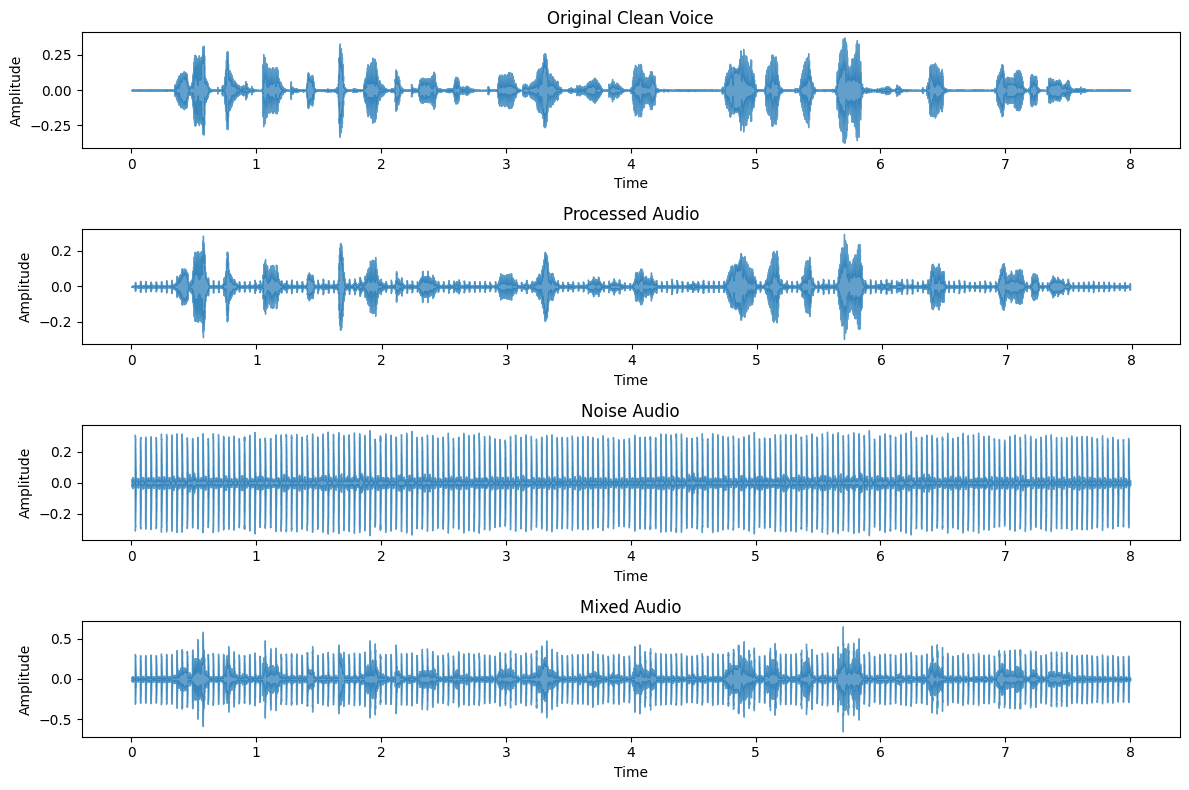

In [22]:
plot_waveform(voice_data[i], spec_sub_out[i], noise_data[i], mixed_data[1], sampling_rate)

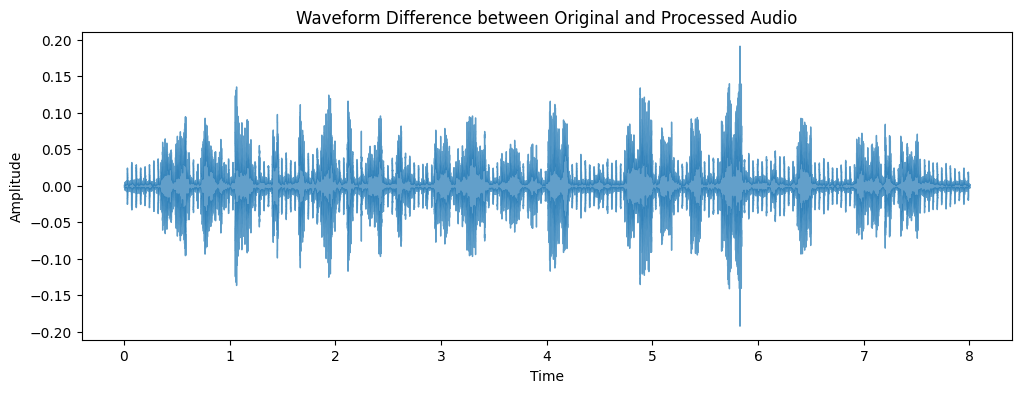

In [23]:
plot_waveform_diff(voice_data[i], spec_sub_out[i], sampling_rate)

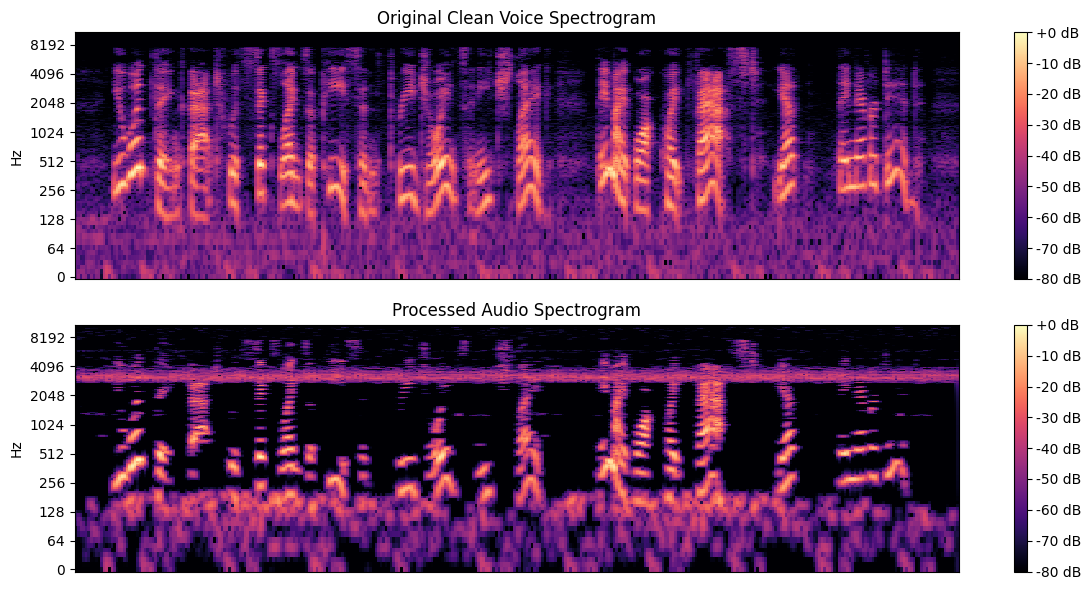

In [24]:
plot_spectrogram(voice_data[i], spec_sub_out[i], sampling_rate)

In [25]:
# Evaluate Results
for i in range(10):
    snr = calculate_snr(spec_sub, noise_data[i])
    print(i, "snr: ", snr)

    # pad data that has length diffeernce due to processing
    voice_padded, spec_sub_padded = pad_data(voice_data[i], spec_sub)
    mse = calculate_mse(voice_padded, spec_sub_padded)
    print(i, "mse: ", mse)
    print()

0 snr:  -11.679391860961914
0 mse:  0.002620765

1 snr:  -7.171606421470642
1 mse:  0.0027427718

2 snr:  6.357618570327759
2 mse:  0.0044049257

3 snr:  -2.2101928293704987
3 mse:  0.0023055924

4 snr:  -14.22791838645935
4 mse:  0.0051947925

5 snr:  0.3337458521127701
5 mse:  0.008674912

6 snr:  -12.158236503601074
6 mse:  0.0068457923

7 snr:  3.717428743839264
7 mse:  0.006702199

8 snr:  11.77045464515686
8 mse:  0.0016598528

9 snr:  10.772091150283813
9 mse:  0.0038406278



In [26]:
snr_values = []
mse_values = []
# Plot MSE
for i in range(len(spec_sub_out)):
    # pad data that has length diffeernce due to processing
    voice_padded, spec_sub_padded = pad_data(voice_data[i], spec_sub)
    mse = calculate_mse(voice_padded, spec_sub_padded)
    mse_values.append(mse)

    snr = calculate_snr(spec_sub, noise_data[i])
    snr_values.append(snr)

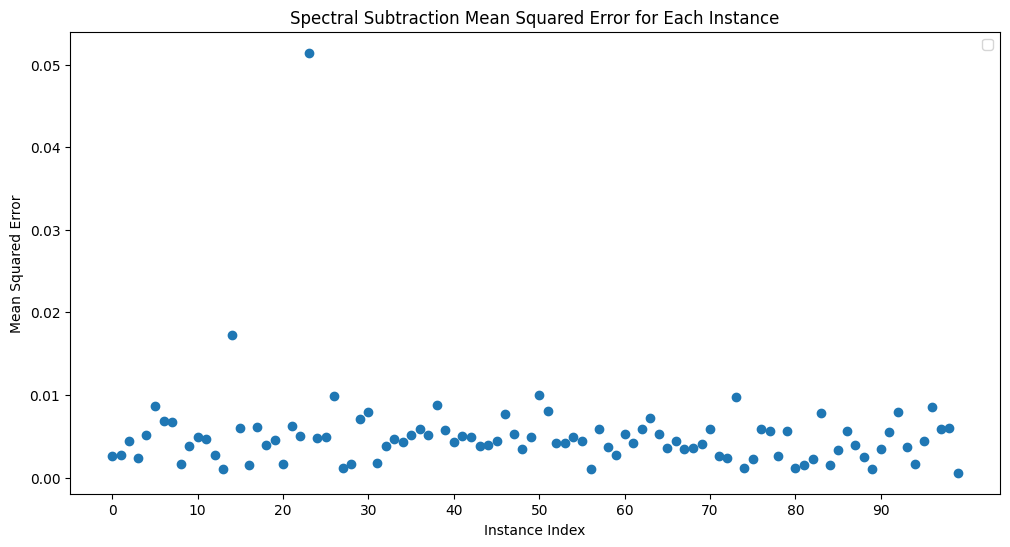

In [27]:
# Plotting the MSE values as dots
plt.figure(figsize=(12, 6))
plt.scatter(range(len(mse_values)), mse_values)
plt.title('Spectral Subtraction Mean Squared Error for Each Instance')
plt.xlabel('Instance Index')
plt.ylabel('Mean Squared Error')
plt.xticks(range(0, len(mse_values), max(1, len(mse_values)//10)))
plt.legend()
plt.show()

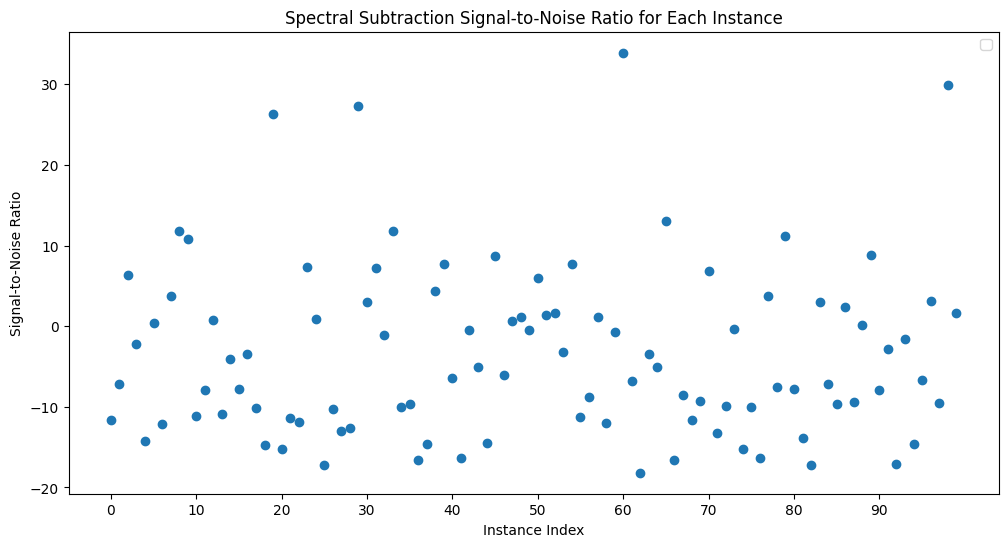

In [28]:
# Plotting the SNR values as dots
plt.figure(figsize=(12, 6))
plt.scatter(range(len(snr_values)), snr_values)
plt.title('Spectral Subtraction Signal-to-Noise Ratio for Each Instance')
plt.xlabel('Instance Index')
plt.ylabel('Signal-to-Noise Ratio')
plt.xticks(range(0, len(snr_values), max(1, len(snr_values)//10)))
plt.legend()
plt.show()

In [29]:
def noise_gate(audio, threshold=0.01, frame_size=1024):
    for i in range(0, len(audio), frame_size):
        frame = audio[i:i+frame_size]
        if np.mean(np.abs(frame)) < threshold:
            audio[i:i+frame_size] = 0
    return audio

In [30]:
noise_gated_out = []
for audio in mixed_data:
    noise_gated = noise_gate(audio)
    noise_gated_out.append(noise_gated)

In [31]:
i = 1
sampling_rate = 22050

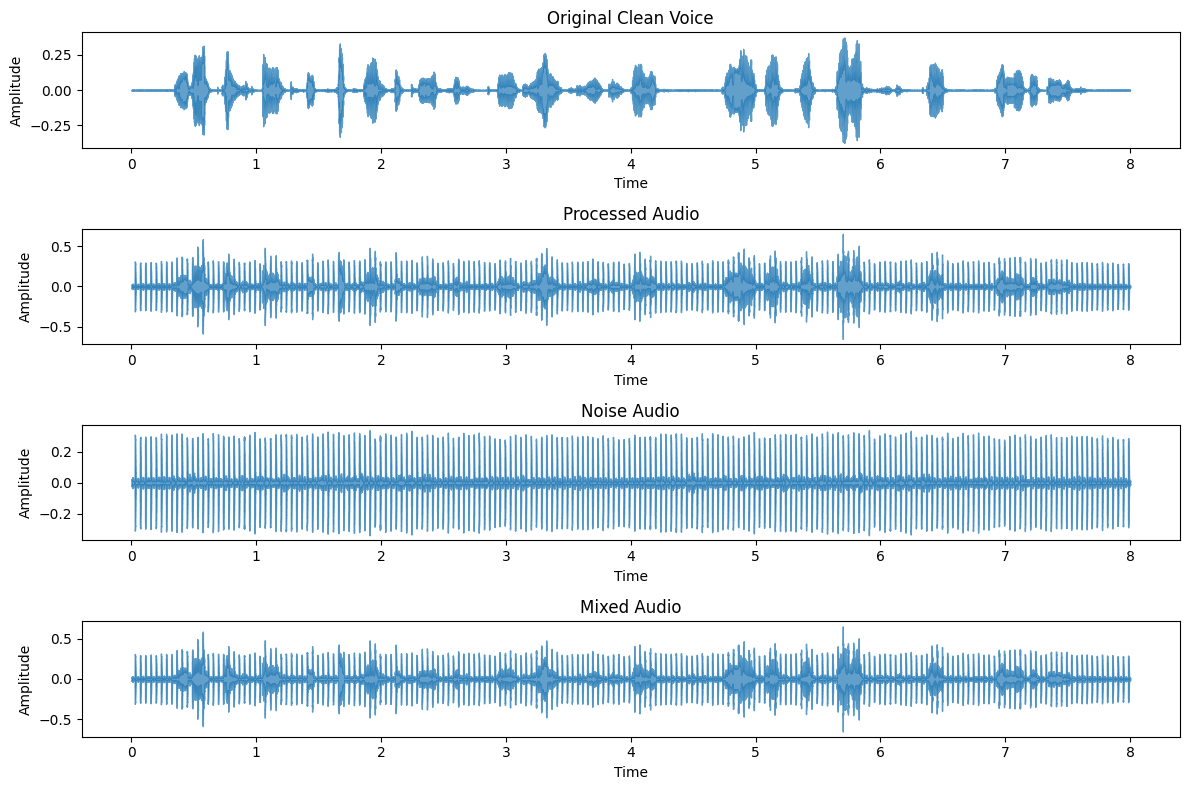

In [32]:
plot_waveform(voice_data[i], noise_gated_out[i], noise_data[i], mixed_data[1], sampling_rate)

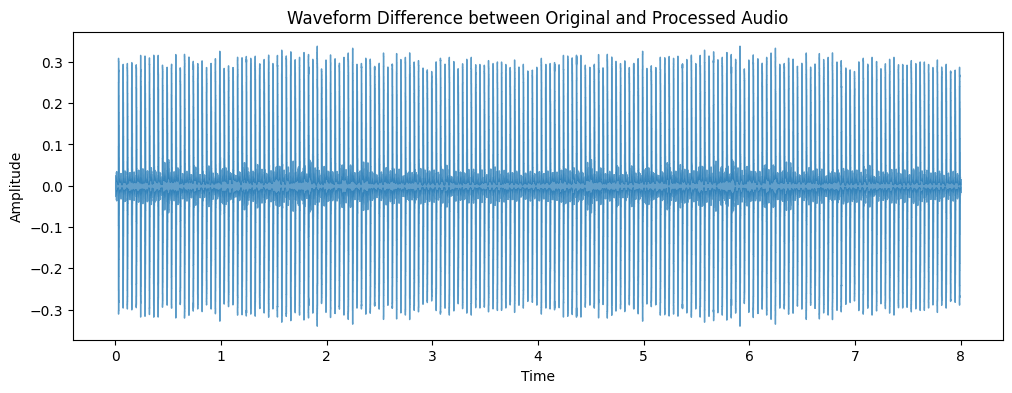

In [33]:
plot_waveform_diff(voice_data[i], noise_gated_out[i], sampling_rate)

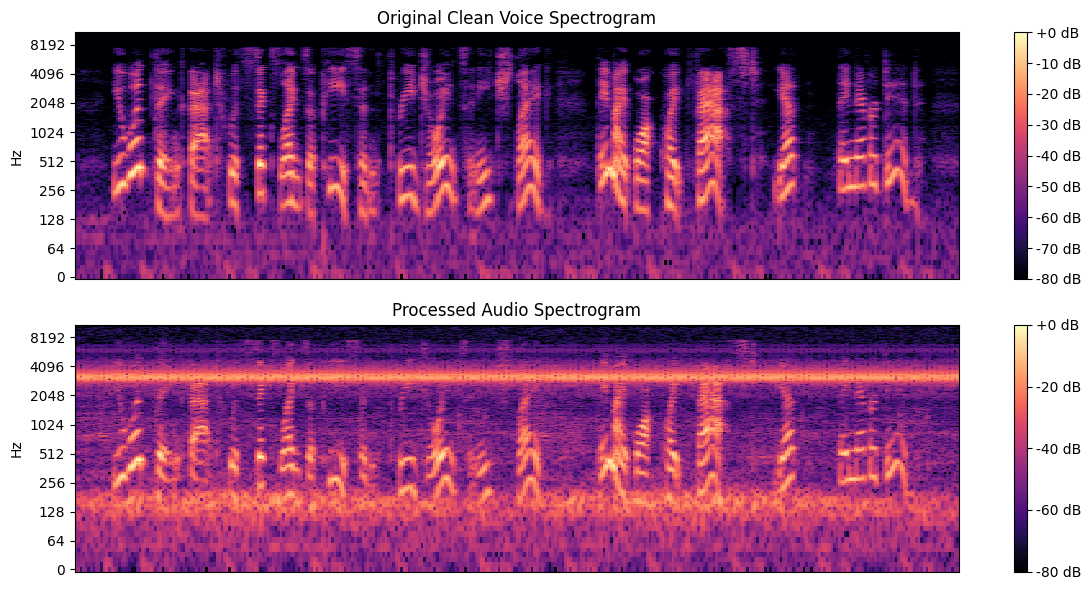

In [34]:
plot_spectrogram(voice_data[i], noise_gated_out[i], sampling_rate)

# ML Method - LSTM

In [35]:
# Data Conversion Methods
def audio_to_mfcc(audio, sr=22050, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs

def audio_to_mel_spec(audio, sr=22050, n_mels=128, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def audio_to_stft(audio, n_fft=2048, hop_length=1381):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    return stft

def stft_to_audio(stft, n_fft=2048, hop_length=1381):
    audio = librosa.istft(stft, n_fft=n_fft, hop_length=hop_length)
    return audio

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Activation
from sklearn.model_selection import train_test_split

In [37]:
max_len = 0

for voice_audio in voice_data:
    max_len = max(len(voice_audio), max_len)

In [38]:
def pad_all_data(data, max_len):
    result = []
    for signal in data:
        padded_signal = np.pad(signal, (0, max_len - len(signal)), 'constant')
        result.append(padded_signal)
#         print(len(padded_signal))
    return np.array(result)

In [39]:
# def pad_audio_data(data, max_len):
#     # Pads or truncates the audio data to max_len
#     return [np.pad(d, (0, max(max_len - len(d), 0)), mode='constant') if len(d) < max_len else d[:max_len] for d in data]

# max_len = max(max(len(d) for d in mixed_data), max(len(d) for d in voice_data))
# padded_mixed_data = pad_audio_data(mixed_data, max_len)
# padded_voice_data = pad_audio_data(voice_data, max_len)

In [40]:
def audio_to_spectrogram(audio_data):
    return [np.abs(audio_to_stft(d)) for d in audio_data]

spectrogram_mixed = np.array(audio_to_spectrogram(mixed_data))
spectrogram_voice = np.array(audio_to_spectrogram(voice_data))

# sanity checks
print("these should match:", spectrogram_mixed.shape, spectrogram_voice.shape)

these should match: (1024, 1025, 128) (1024, 1025, 128)


In [41]:
train_size = int(0.8 * len(spectrogram_mixed))

In [42]:
X_train = spectrogram_mixed[:train_size]
X_test = spectrogram_mixed[train_size:]
y_train = spectrogram_voice[:train_size]
y_test = spectrogram_voice[train_size:]

In [43]:
print("X train len:", len(X_train))
print("X test len:", len(X_test))
print("y train len:", len(y_train))
print("y test len:", len(y_test))

X train len: 819
X test len: 205
y train len: 819
y test len: 205


In [44]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(TimeDistributed(Dense(input_shape[1], activation='linear')))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [45]:
num_samples, num_timesteps, num_features = X_train.shape
input_shape = (num_timesteps, num_features)
print("input shape:",input_shape)

input shape: (1025, 128)


In [46]:
lstm_model = build_lstm_model(input_shape)

In [47]:
!pip install pydot

In [48]:
!pip install graphviz

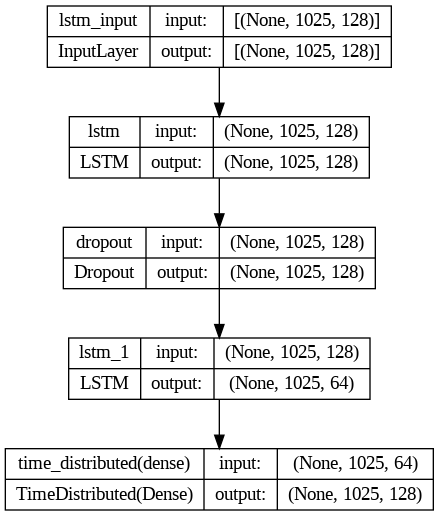

In [49]:
from tensorflow.keras.utils import plot_model

# from tensorflow.keras.utils import plot_model
plot_model(lstm_model, to_file='lstm_model_plot.png', show_shapes=True, show_layer_names=True)

In [50]:
history = lstm_model.fit(np.array(X_train), np.array(y_train), epochs=30, batch_size=32, validation_split=0.2)
lstm_model.save('./lstm_2layer_model.h5')

Epoch 1/30
21/21 [==============================] - 10s 138ms/step - loss: 3.5790 - mean_squared_error: 3.5790 - mean_absolute_error: 0.3872 - val_loss: 3.4197 - val_mean_squared_error: 3.4197 - val_mean_absolute_error: 0.4077
Epoch 2/30
21/21 [==============================] - 2s 79ms/step - loss: 3.3558 - mean_squared_error: 3.3558 - mean_absolute_error: 0.4006 - val_loss: 3.2328 - val_mean_squared_error: 3.2328 - val_mean_absolute_error: 0.4079
Epoch 3/30
21/21 [==============================] - 2s 84ms/step - loss: 3.2298 - mean_squared_error: 3.2298 - mean_absolute_error: 0.3936 - val_loss: 3.1492 - val_mean_squared_error: 3.1492 - val_mean_absolute_error: 0.3818
Epoch 4/30
21/21 [==============================] - 2s 81ms/step - loss: 3.1529 - mean_squared_error: 3.1529 - mean_absolute_error: 0.3866 - val_loss: 3.0930 - val_mean_squared_error: 3.0930 - val_mean_absolute_error: 0.3849
Epoch 5/30
21/21 [==============================] - 2s 78ms/step - loss: 3.1056 - mean_squared_err

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


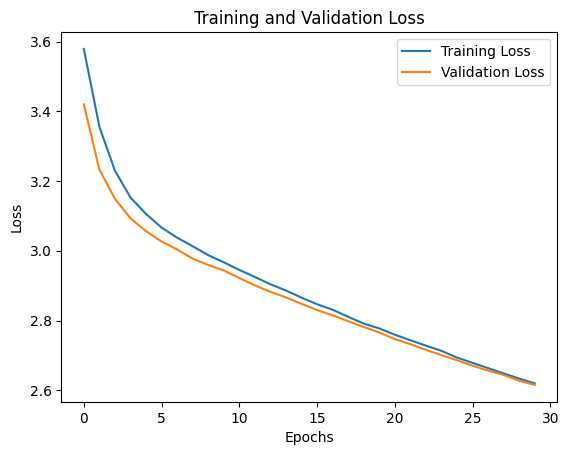

In [51]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

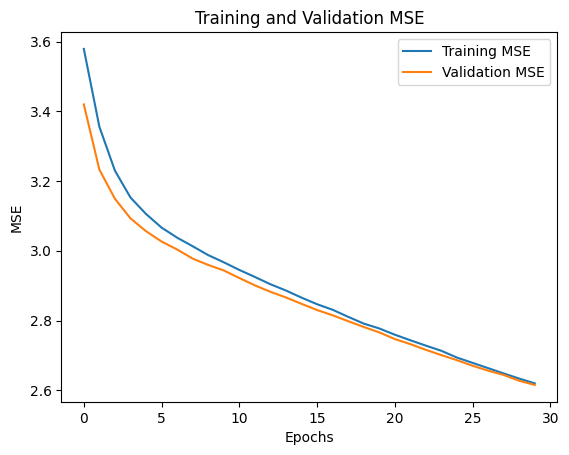

In [52]:
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

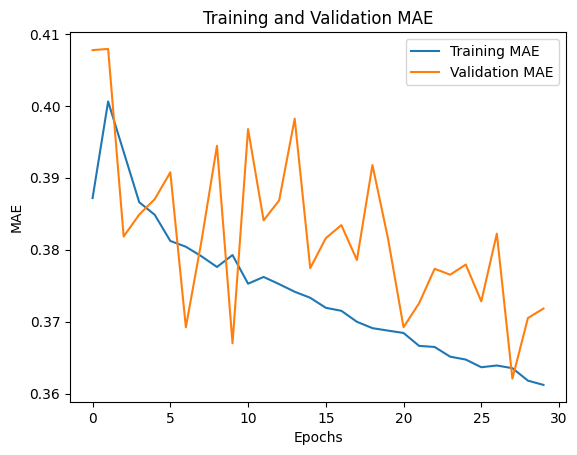

In [53]:
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [54]:
# model = tf.keras.models.load_model('lstm_2layer_model.h5')

def spectrogram_to_audio(spectrogram):
    return [stft_to_audio(d) for d in spectrogram]

predicted_spectrogram = lstm_model.predict(np.array(X_test))

7/7 [==============================] - 1s 35ms/step


In [55]:
predicted_audio = spectrogram_to_audio(predicted_spectrogram)

In [56]:
i = 1
sampling_rate = 22050
sf.write(out_dir + f'lstm_predicted_audio{i}.wav', predicted_audio[i], sampling_rate)
sf.write(out_dir + f'lstm_voice-audio{i}.wav', voice_data[i], sampling_rate)
sf.write(out_dir + f'lstm_noise_audio{i}.wav', noise_data[i], sampling_rate)
sf.write(out_dir + f'lstm_mixed_audio{i}.wav', mixed_data[i], sampling_rate)

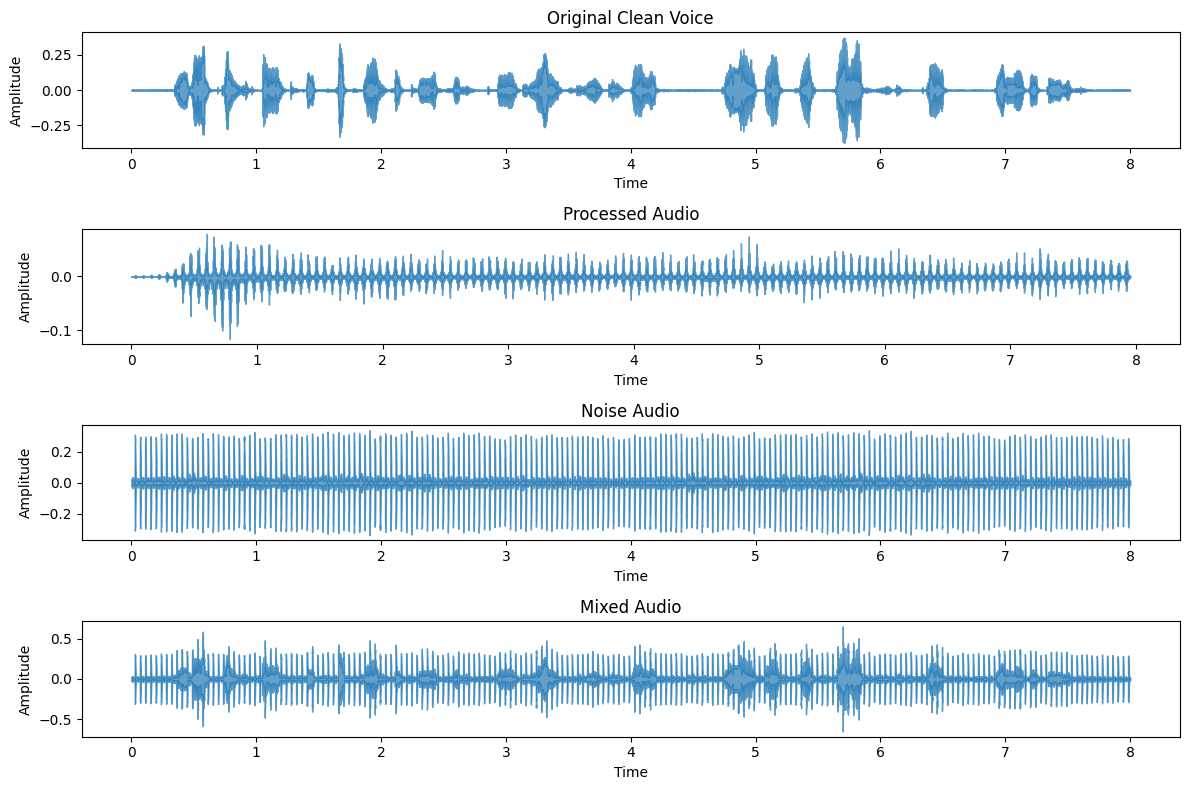

In [57]:
plot_waveform(voice_data[i], np.array(predicted_audio), noise_data[i], mixed_data[1], sampling_rate)

In [58]:
batch_size = 1
X_train_wave = np.array(mixed_data[:train_size])
X_test_wave = np.array(mixed_data[train_size:])
y_train_wave = np.array(voice_data[:train_size])
y_test_wave = np.array(voice_data[train_size:])

X_train_wave = X_train_wave.reshape(X_train_wave.shape[0], X_train_wave.shape[1], batch_size)
X_test_wave = X_test_wave.reshape(X_test_wave.shape[0],X_test_wave.shape[1], batch_size)
y_train_wave = y_train_wave.reshape(y_train_wave.shape[0], y_train_wave.shape[1], batch_size)
y_test_wave = y_test_wave.reshape(y_test_wave.shape[0], y_test_wave.shape[1], batch_size)

In [59]:
num_samples, amplitude_over_time, batch_size = X_train_wave.shape
input_shape = (amplitude_over_time, batch_size)
print("input shape:",input_shape)

input shape: (176400, 1)


In [60]:
# # using just the audio data loaded from librosa
# # This is a one-dimensional NumPy array that represents the audio waveform.
# # Each element of the array corresponds to the amplitude of the audio signal at
# #a specific point in time.
# lstm_waveform_model = build_lstm_model(input_shape)

In [61]:
# from tensorflow.keras.utils import plot_model


In [62]:
# plot_model(lstm_waveform_model, to_file='lstm_wave_model_plot.png', show_shapes=True, show_layer_names=True)

In [63]:
# history = lstm_waveform_model.fit(X_train_wave, y_train_wave, epochs=30, batch_size=32, validation_split=0.2)
# lstm_waveform_model.save('./lstm_2layer_waveform_model.h5')

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LSTM, Dense, Flatten, Reshape, BatchNormalization

def build_crn_model(input_shape):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    # Flatten and reshape for LSTM layers
    model.add(Flatten())
    # Assuming the time dimension is the first dimension
    time_steps = input_shape[0]
    num_features = model.output_shape[1] // time_steps
    model.add(Reshape((time_steps, num_features)))
    print(time_steps, num_features)

    # LSTM layers
    model.add(LSTM(input_shape[1], return_sequences=True)) # careful with large shape
    model.add(LSTM(input_shape[1], return_sequences=True))

    # Reshape back for deconvolutional layers
    reshaped_height = input_shape[0]
    reshaped_width = input_shape[1]
    reshaped_channels = 1
    model.add(Reshape((reshaped_height, reshaped_width, reshaped_channels)))

    # Deconvolutional layers
    model.add(Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(16, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    # Final output layer
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [65]:
# add channel dimension for convolutional layer
X_train_conv = np.expand_dims(X_train, axis=-1)
X_test_conv = np.expand_dims(X_train, axis=-1)
y_train_conv = np.expand_dims(y_train, axis=-1)
y_test_conv = np.expand_dims(y_test, axis=-1)

conv_input_shape = X_train_conv.shape[1:]
print("conv shape:", conv_input_shape) # time steps, features, channels

conv shape: (1025, 128, 1)


In [66]:
crn_model = build_crn_model(conv_input_shape)

1025 16384


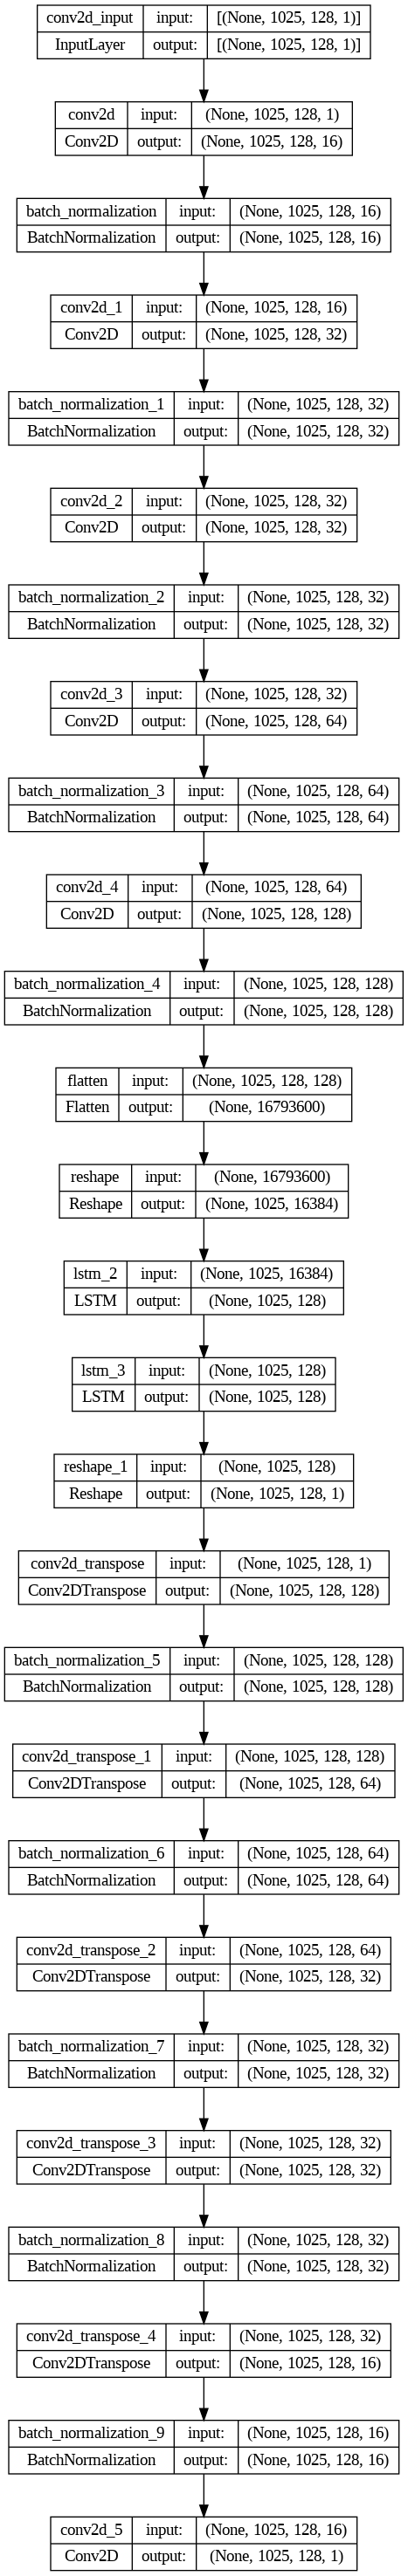

In [67]:
plot_model(crn_model, to_file='crn_model_plot.png', show_shapes=True, show_layer_names=True)

In [68]:
history = crn_model.fit(X_train_conv, y_train_conv, epochs=30, batch_size=32, validation_split=0.2)
crn_model.save('./crn_model.h5')

Epoch 1/30
21/21 [==============================] - 35s 758ms/step - loss: 3.4667 - mean_squared_error: 3.4667 - mean_absolute_error: 0.5224 - val_loss: 3.5873 - val_mean_squared_error: 3.5873 - val_mean_absolute_error: 0.6645
Epoch 2/30
21/21 [==============================] - 10s 460ms/step - loss: 3.3850 - mean_squared_error: 3.3850 - mean_absolute_error: 0.4222 - val_loss: 3.6706 - val_mean_squared_error: 3.6706 - val_mean_absolute_error: 0.7817
Epoch 3/30
21/21 [==============================] - 10s 460ms/step - loss: 3.3671 - mean_squared_error: 3.3671 - mean_absolute_error: 0.3890 - val_loss: 3.6726 - val_mean_squared_error: 3.6726 - val_mean_absolute_error: 0.7766
Epoch 4/30
21/21 [==============================] - 10s 461ms/step - loss: 3.3553 - mean_squared_error: 3.3553 - mean_absolute_error: 0.3730 - val_loss: 3.5987 - val_mean_squared_error: 3.5987 - val_mean_absolute_error: 0.6891
Epoch 5/30
21/21 [==============================] - 10s 461ms/step - loss: 3.3438 - mean_squ

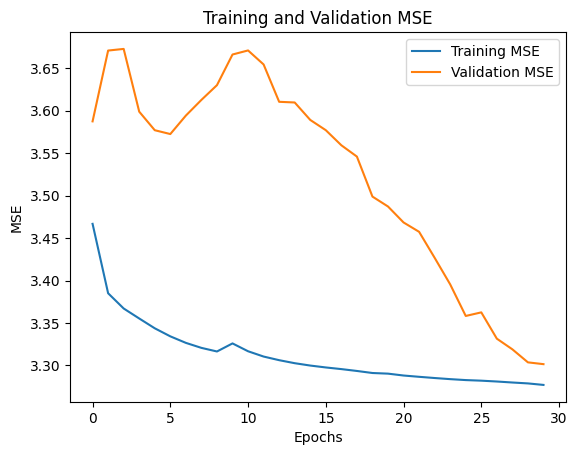

In [69]:
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

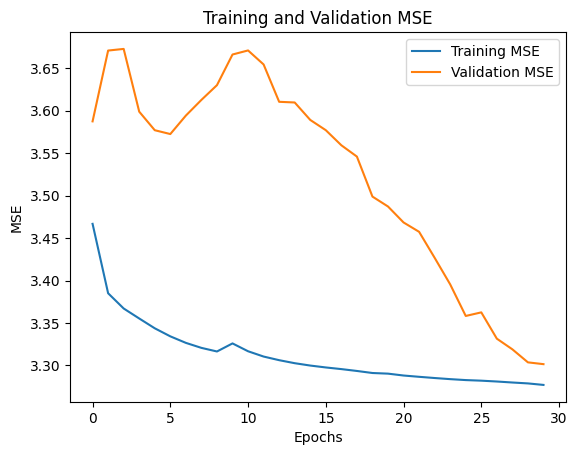

In [70]:
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

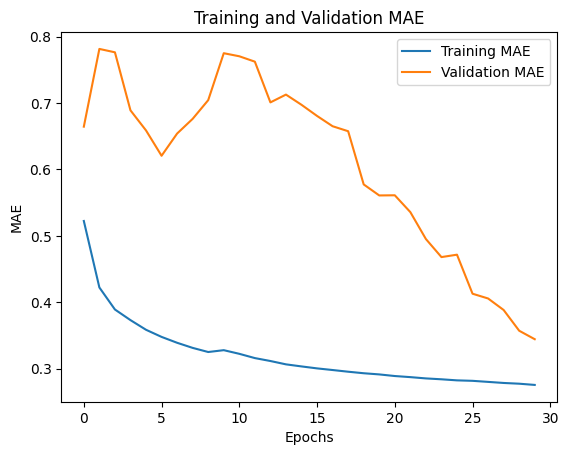

In [71]:
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [72]:
predicted_spectrogram_conv = crn_model.predict(np.array(X_test))
# remove channel
predicted_spectrogram = np.squeeze(predicted_spectrogram_conv, axis=-1)

7/7 [==============================] - 3s 370ms/step


In [73]:
print(predicted_spectrogram_conv.shape)
print(predicted_spectrogram.shape)

(205, 1025, 128, 1)
(205, 1025, 128)


In [74]:
predicted_audio = spectrogram_to_audio(predicted_spectrogram)

In [75]:
i = 1
sampling_rate = 22050
sf.write(out_dir + f'crn_predicted_audio{i}.wav', predicted_audio[i], sampling_rate)
sf.write(out_dir + f'crn_voice-audio{i}.wav', voice_data[i], sampling_rate)
sf.write(out_dir + f'crn_noise_audio{i}.wav', noise_data[i], sampling_rate)
sf.write(out_dir + f'crn_mixed_audio{i}.wav', mixed_data[i], sampling_rate)

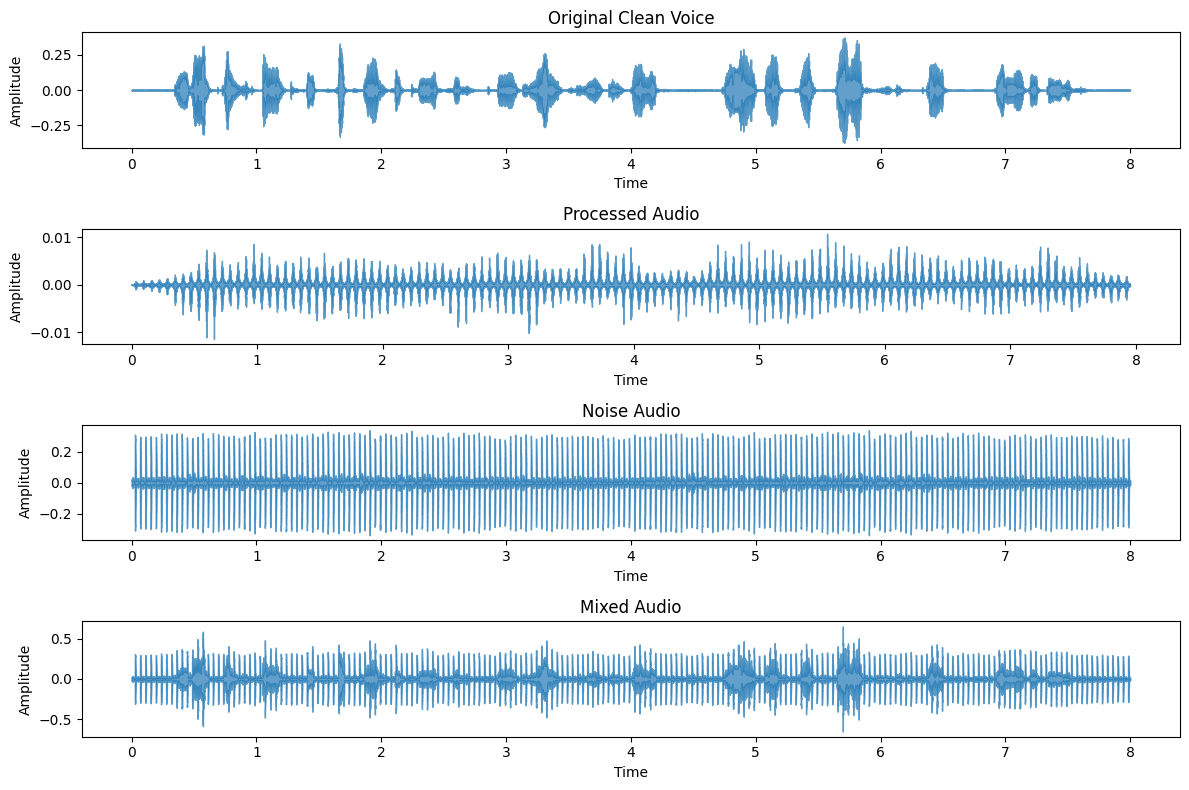

In [76]:
plot_waveform(voice_data[i], np.array(predicted_audio), noise_data[i], mixed_data[1], sampling_rate)

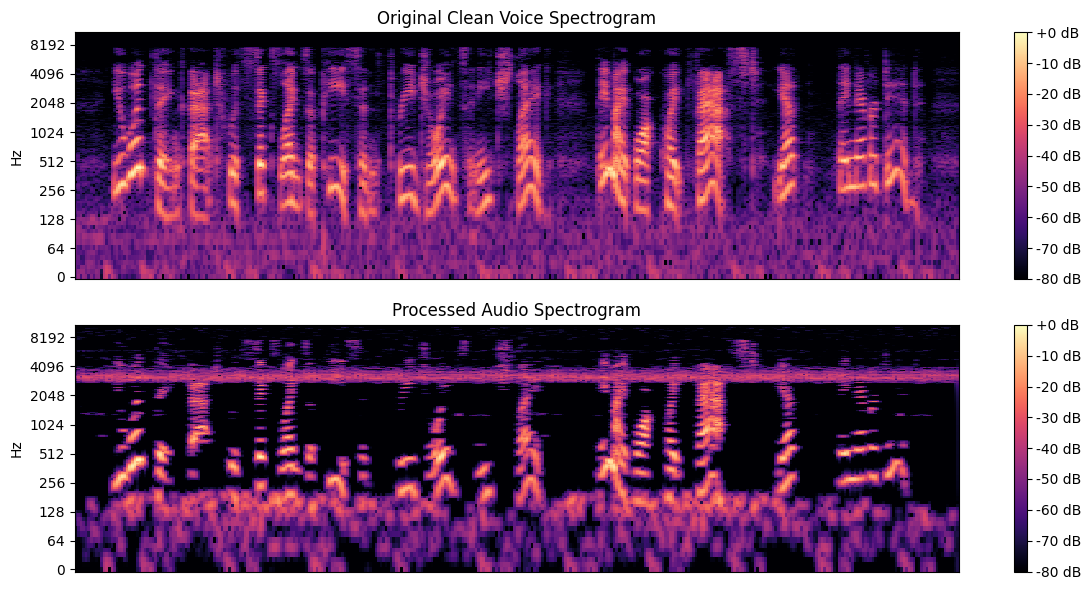

In [77]:
plot_spectrogram(voice_data[i], spec_sub_out[i], sampling_rate)

In [78]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LSTM, Dense, Flatten, Reshape, BatchNormalization, Input, Attention, Concatenate
from tensorflow.keras.models import Model

def build_crn_attention_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)

    # Flatten and reshape for LSTM and Attention layers
    flattened = Flatten()(conv3)
    time_steps = input_shape[0]
    num_features = flattened.shape[1] // time_steps
    reshaped = Reshape((time_steps, num_features))(flattened)

    # LSTM layer
    lstm_out = LSTM(num_features, return_sequences=True)(reshaped)

    # Attention layer
    attention_out = Attention()([reshaped, reshaped])  # Query and key are the same in this case

    # Combine LSTM and Attention outputs
    combined_out = Concatenate()([lstm_out, attention_out])

    # Reshape for Deconvolutional layers
    reshaped_height = input_shape[0]
    reshaped_width = input_shape[1]
    reshaped_channels = 64  # Adjust as needed
    combined_reshaped = Reshape((reshaped_height, reshaped_width, reshaped_channels))(combined_out)

    # Deconvolutional layers
    deconv1 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(combined_reshaped)
    deconv1 = BatchNormalization()(deconv1)
    deconv2 = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(deconv1)
    deconv2 = BatchNormalization()(deconv2)
    deconv3 = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(deconv2)
    deconv3 = BatchNormalization()(deconv3)

    # Final output layer
    final_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(deconv3)

    # Create the model
    model = Model(inputs=inputs, outputs=final_output)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])

    return model

In [79]:
# add channel dimension for convolutional layer
X_train_conv = np.expand_dims(X_train, axis=-1)
X_test_conv = np.expand_dims(X_train, axis=-1)
y_train_conv = np.expand_dims(y_train, axis=-1)
y_test_conv = np.expand_dims(y_test, axis=-1)

conv_input_shape = X_train_conv.shape[1:]
print("conv shape:", conv_input_shape) # time steps, features, channels

conv shape: (1025, 128, 1)


In [80]:
# crashes due to not enough RAM :(
# crn_attention_model = build_crn_attention_model(conv_input_shape)

In [ ]:
# plot_model(crn_model, to_file='crn_att_model_plot.png', show_shapes=True, show_layer_names=True)